In [1]:
# PS: maybe build in a little pie chart or such to have a look at diagnosed, vs perceived mental health of employees vs. self-employed
# Graphics and diagrams ideas:
        # Mentalhealth different locations
        # Mental healt correlation of comp size
        # mh correlation of different jobs
        # mh correlation of openness via things liike the comfort to discuss mh, and the company showing intiative and Actual Mental health
        # Bad experiences with mental health

In [2]:
# Possible Angles:
    # Predicting mental health existenc:
        # kinda failed as can be seen by ANOVA Test
   
#  How can we accomplish a culture of trust and openness, so what are the features that influence the following features:
        # "Do you think that discussing a mental health disorder with your employer would have negative consequences?" : "neg_consequences_discussing_mh" ,
        # "Do you think that discussing a physical health issue with your employer would have negative consequences?" : "neg_consequences_discussing_ph" ,
        # For this we need to create a new feature perhaps and to check if people ever had any mental health issues at any given point so if people have been diagnoes, if they currently have a mental health issue
        # or if they previously had a mental health issue
        # Can be extended to:
            #"Would you feel comfortable discussing a mental health disorder with your coworkers?" : "comf_discussing_mh_with_coworker_indic" ,
            # "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_indic" ,

    # What type of people have the feeling that their mental health issues (treated or untreated) are effecting their work and can we prevent this:
        # The necessary features are:
            # "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?" : "interference_mh_treated_with_work" ,
            # "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?" : "interference_mh_untreated_with_work" ,
            # For this to work we need a new feature that is "mh_inf_work"
                # if "interference_mh_treated_with_work" = Y OR "interference_mh_untreated_with_work" = Y then effect on work

## 1. Libraries & Importing Dataset

In [3]:
import polars as pl
import unicodedata
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder , TargetEncoder , RobustScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

# Define the input CSV file and create a DataFrame
csv = 'input.csv'
df_csv = pl.read_csv(csv)

## 2. Data Exploration

In [4]:
# Get the shape of dataframe
print(df_csv.shape)

(1433, 63)


In [5]:
# Get insights into Statistics. DF too large for useful information
df_csv.describe()

statistic,Are you self-employed?,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?,Do you have medical coverage (private insurance or state-provided) which includes treatment of mental health issues?,Do you know local or online resources to seek help for a mental health disorder?,"If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?","If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?","If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?","If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?",Do you believe your productivity is ever affected by a mental health issue?,"If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?",Do you have previous employers?,Have your previous employers provided mental health benefits?,Were you aware of the options for mental health care provided by your previous employers?,Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?,Did your previous employers provide resources to learn more about mental health issues and how to seek help?,Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?,Do you think that discussing a mental health disorder with previous employers would have negative consequences?,Do you think that discussing a physical health issue with previous employers would have negative consequences?,Would you have been willing to discuss a mental health issue with your previous co-workers?,Would you have been willing to discuss a mental health issue with your direct supervisor(s)?,Did you feel that your previous employers took mental health as seriously as physical health?,Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?,Would you be willing to bring up a physical health issue with a potential employer in an interview?,Why or why not?,Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?_duplicated_0,Do you feel that being identified as a person with a mental health issue would hurt your career?,Do you think that team members/co-workers would view you more negatively if they knew you s

In [6]:
# First look at a couple of entries
df_csv.glimpse(max_items_per_column=10)
# Insights include: Some Categoricals are 0,1 even though it could be yes or no, some questions are for self-employed which can be dropped
# Column names are hard to work with and need to be renamed
# Lots of textual data, needs unicode normalization and natural language processing (?TF-IDF?)
# Imputation necessary for Null values

Rows: 1433
Columns: 63
$ Are you self-employed?                             <i64> 0, 0, 0, 1, 0, 0, 0, 0, 0, 1
$ How many employees does your company or organizat… <str> '26-100', '6-25', '6-25', None, '6-25', 'More than 1000', '26-100', 'More than 1000', '26-100', None
$ Is your employer primarily a tech company/organiz… <i64> 1, 1, 1, None, 0, 1, 1, 1, 0, None
$ Is your primary role within your company related … <i64> None, None, None, None, 1, None, None, None, 1, None
$ Does your employer provide mental health benefits… <str> 'Not eligible for coverage / N/A', 'No', 'No', None, 'Yes', 'Yes', "I don't know", 'Yes', "I don't know", None
$ Do you know the options for mental health care av… <str> 'N/A', 'Yes', 'N/A', None, 'Yes', 'I am not sure', 'No', 'Yes', 'No', None
$ Has your employer ever formally discussed mental … <str> 'No', 'Yes', 'No', None, 'No', 'No', 'No', 'No', 'No', None
$ Does your employer offer resources to learn more … <str> 'No', 'Yes', 'No', None, 'No', 'Yes', 'No

In [7]:
# Investigate the amount of USA workers
# 840 is 59%
# Quick win could be visualization of which countires have the most diagnosis vs the most perceived mental health issues
# More in depth could be which states have the most mental health issues
# For this although you should investigate some percentages instead of absolute values because that could be tricky
df_csv.select(pl.col("What country do you live in?") == "United States of America").filter(pl.col("What country do you live in?") == True)

What country do you live in?
bool
true
true
true
true
true
…
true
true
true


## 3. Unicode Normalization

In [8]:
# Unicode normalization to prevent major difficulties with any weird strings
string_df = df_csv.select(pl.col(pl.String))

df_normalized = df_csv.with_columns(
    df_csv.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFD" , str(x)) , return_dtype=pl.String))
)

df = df_normalized.with_columns(
    df_normalized.select(pl.col(pl.String).map_elements(lambda x : unicodedata.normalize("NFC" , str(x)) , return_dtype=pl.String))
)

## 4. Renaming Columns

In [9]:
# Here we rename the columns
# Create a list of all column names to preserve the originals for later
col_names = df.columns

# Dictionary to rename columns
new_names = { "Are you self-employed?" : "self-employed_indic" ,
             "How many employees does your company or organization have?" : "comp_size" ,
             "Is your employer primarily a tech company/organization?" : "tech_comp_indic" ,
             "Is your primary role within your company related to tech/IT?" : "tech_role_indic",
             "Does your employer provide mental health benefits as part of healthcare coverage?" : "availability_of_benefits" ,
             "Do you know the options for mental health care available under your employer-provided coverage?" : "awareness_of_benefits" , 
             "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?" : "mh_discussion_indic" ,
             "Does your employer offer resources to learn more about mental health concerns and options for seeking help?" : "mh_resources_availability_indic" ,
             "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?" : "anonym_use_benefit_indic" ,
             "If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:" : "sick_leave_difficulty" ,
             "Do you think that discussing a mental health disorder with your employer would have negative consequences?" : "neg_consequences_discussing_mh" ,
             "Do you think that discussing a physical health issue with your employer would have negative consequences?" : "neg_consequences_discussing_ph" ,
             "Would you feel comfortable discussing a mental health disorder with your coworkers?" : "comf_discussing_mh_with_coworker_indic" ,
             "Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_indic" ,
             "Do you feel that your employer takes mental health as seriously as physical health?" : "employer_importance_mh_vs_ph" ,
             "Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?" : "known_neg_consequences_of_mh" ,
             "Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?" : "med_coverage_mh_indic" ,
             "Do you know local or online resources to seek help for a mental health disorder?" : "known_mh_sources" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?" : "mention_mh_to_clients" ,
             "If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_client_of_mh" ,
             "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?" : "mention_mh_to_employees" ,
             "If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?" : "neg_impact_of_reveal_to_employee_of_mh" ,
             "Do you believe your productivity is ever affected by a mental health issue?" : "productivity_effect_of_mh" ,
             "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?" : "time_effect_of_mh" ,
             "Do you have previous employers?" : "prev_employers" ,
             "Have your previous employers provided mental health benefits?" : "availability_of_benefits_prev_employer" , 
             "Were you aware of the options for mental health care provided by your previous employers?" : "awareness_of_benefits_prev_employer" ,
             "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?" : "mh_discussion_indic_prev_employer" ,
             "Did your previous employers provide resources to learn more about mental health issues and how to seek help?" : "mh_resources_availability_indic_prev_employer" ,
             "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?" : "anonym_use_benefit_indic_prev_employer" ,
             "Do you think that discussing a mental health disorder with previous employers would have negative consequences?" : "neg_consequences_discussing_mh_prev_employer" , 
             "Do you think that discussing a physical health issue with previous employers would have negative consequences?" : "neg_consequences_discussing_ph_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your previous co-workers?" : "comf_discussing_mh_with_coworker_prev_employer" ,
             "Would you have been willing to discuss a mental health issue with your direct supervisor(s)?" : "comf_discussing_mnh_with_supervisor_prev_employer" ,
             "Did you feel that your previous employers took mental health as seriously as physical health?" : "employer_importance_mh_vs_ph_prev_employer" ,
             "Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?" : "known_neg_consequences_of_mh_prev_employer" ,
             "Would you be willing to bring up a physical health issue with a potential employer in an interview?" : "willing_discuss_ph_in_hiring_interview" ,
             "Why or why not?" : "why_why_not_1" ,
             "Would you bring up a mental health issue with a potential employer in an interview?" : "willing_discuss_mh_in_hiring_interview" ,
             "Why or why not?2" : "why_why_not_2" ,
             "Do you feel that being identified as a person with a mental health issue would hurt your career?" : "percevied_neg_impact_carreer_of_mh" ,
             "Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?" : "perceived_neg_impact_coworker_opiniton_of_mh" ,
             "How willing would you be to share with friends and family that you have a mental illness?" : "willingness_to_share_with_friend_family" ,
             "Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?" : "neg_response_to_mh" ,
             "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?" : "willingness_to_share_mh_after_observation" ,
             "Do you have a family history of mental illness?" : "mh_family_hist" ,
             "Have you had a mental health disorder in the past?" : "previous_mh" ,
             "Do you currently have a mental health disorder?" : "current_mh" ,
             "If yes, what condition(s) have you been diagnosed with?" :  "diagnosis_name_condition" ,
             "If maybe, what condition(s) do you believe you have?" : "believed_name_condiiton" ,
             "Have you been diagnosed with a mental health condition by a medical professional?" : "diagnosis_professional" ,
             "If so, what condition(s) were you diagnosed with?" : "diagnosis_name_professional_condition" ,
             "Have you ever sought treatment for a mental health issue from a mental health professional?" : "used_therapy" ,
             "If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?" : "interference_mh_treated_with_work" ,
             "If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?" : "interference_mh_untreated_with_work" ,
             "What is your age?" : "age" ,
             "What is your gender?" : "gender" ,
             "What country do you live in?" : "country_residency" ,
             "What US state or territory do you live in?" : "usa_state_residency" ,
             "What country do you work in?" : "country_work" ,
             "What US state or territory do you work in?" : "usa_state_work" ,
             "Which of the following best describes your work position?" : "job_title" ,
             "Do you work remotely?" : "remote" ,
            }

# Rename the keys in the dictionary with the names of the original DataFrame. This has to be done because I copied the titles from excel which was stupid and I made a mistake
new_names = dict((col_names[list(new_names.keys()).index(key)], value) for key, value in new_names.items())
df = df.rename(new_names).with_row_index("index")

## 5. Handling Self-employed Features

In [10]:
# Drop all columns that are meant for self-employed and filter out the people that are self-employed
df = df.filter(pl.col("self-employed_indic") != 1)
df = df.drop("self-employed_indic")

## 6. Investigating Null values

In [11]:
# Count columns with null values and those without
null_counts = df.null_count()

# Transpose the dataframe to write the amount of null values entriewise
null_counts_trans = null_counts.transpose(include_header= True)
null_counts_trans = null_counts_trans.filter(pl.col('column')!='index')
# Get the number of columns with null values and without
true_null_counts = null_counts_trans.filter(pl.col("column_0") == 0).shape[0]
non_null_counts = null_counts_trans.filter(pl.col("column_0") != 0).shape[0]


# Calculate the percentage of NULL values per column and get the number
null_counts_perc = null_counts_trans.with_columns((pl.col("column_0") / df.shape[0] * 100).cast(pl.Int32).alias("null_perc") )

# Get the number of columns with 0 percent nulls, according to the percentages.
non_null_counts = null_counts_perc.filter(pl.col('null_perc') == 0).shape[0]

[Text(0, 0, '34'), Text(0, 0, '17'), Text(0, 0, '11')]

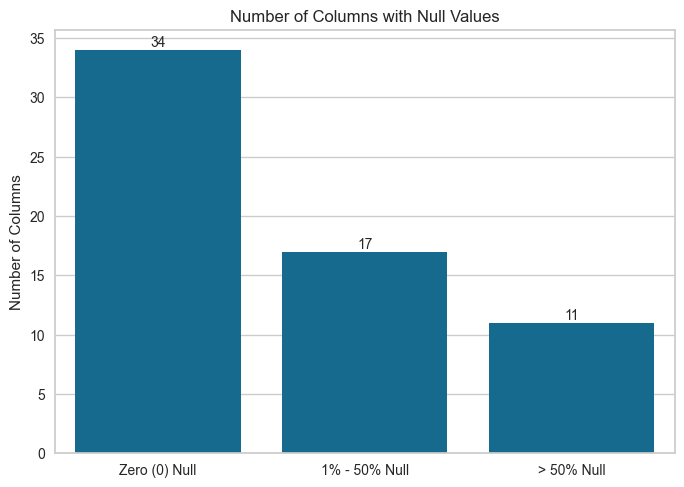

In [12]:
# Construct the number of Columns with exactly 0% null values
num_null_counts_zero_perc = null_counts_perc.filter(pl.col("null_perc") ==0).shape[0]

# Construct the number for columns with less than 50% of null values but more than 0% null values
num_null_counts_below_50_perc = null_counts_perc.filter((pl.col('null_perc') <= 50) & (pl.col('null_perc') > 0)).shape[0]

# Construct the number for columns with more than 50% null values
num_null_counts_exc_50_perc = null_counts_perc.filter(pl.col("null_perc") > 50).shape[0]


# Create a dictionary with the relevant information
nulls_dict = {"Zero (0) Null" : non_null_counts , "1% - 50% Null" : num_null_counts_below_50_perc ,  "> 50% Null" : num_null_counts_exc_50_perc}
# Plot the amount of columns with null values
ax = sns.barplot(data=nulls_dict)
ax.set(xlabel='' , ylabel='Number of Columns')
ax.set_title("Number of Columns with Null Values")
ax.bar_label(ax.containers[0], fontsize=10)

### Null Value Handling

In [13]:
# Drop all columns with more than 50% Null values. NOT YET!!!!!!!!!
# First look at the columns with more than 50% Null Values
drop_col_list = pl.Series(null_counts_perc.filter(pl.col("null_perc")>50).select(pl.col("column"))).to_list()
print(drop_col_list)

# tech_role_indic can perhaps be imputed via the job title

['tech_role_indic', 'med_coverage_mh_indic', 'known_mh_sources', 'mention_mh_to_clients', 'neg_impact_of_reveal_to_client_of_mh', 'mention_mh_to_employees', 'neg_impact_of_reveal_to_employee_of_mh', 'productivity_effect_of_mh', 'time_effect_of_mh', 'diagnosis_name_condition', 'believed_name_condiiton']


#### Standardizing answers of categorical features

In [14]:
# Standardize all categorical columsn that are currently answered with 0/1 instead of yes/no
df = df.with_columns(
    pl.when(pl.col('tech_comp_indic') == 1).then(pl.lit('yes')).when(pl.col('tech_comp_indic') == 0).then(pl.lit('no')).alias('tech_comp_indic') ,
    pl.when(pl.col('tech_role_indic') == 1).then(pl.lit('yes')).when(pl.col('tech_role_indic') == 0).then(pl.lit('no')).alias('tech_role_indic') ,
    pl.when(pl.col('used_therapy') == 1).then(pl.lit('yes')).when(pl.col('used_therapy') == 0).then(pl.lit('no')).alias('used_therapy')          ,                          
    pl.when(pl.col('prev_employers') == 1).then(pl.lit('yes')).when(pl.col('prev_employers') == 0).then(pl.lit('no')).alias('prev_employers')
)

### Imputation of Null Values

In [15]:
# Convert all strings to lower case
df = df.with_columns(pl.col(pl.String).str.to_lowercase())

##### Imputation of feature: 'tech_role_indic'

In [16]:
# Now lets find the list of tech jobs
tech_jobs_list =  df.filter(pl.col("tech_role_indic") == pl.lit('yes')).select("job_title").rows()

# Job list is currently a list nested of tuples
# Define function to flatten nested list
def flatten_list(list_input):
    job_list = []
    for x in list_input:
        job_list.extend(x)
    return job_list

# Clear job_list of any nested tuples and splitters
job_list = flatten_list(tech_jobs_list)
job_list = [x.split('|') for x in job_list]
job_list = flatten_list(job_list)
job_list = [x.split('/') for x in job_list]
job_list = flatten_list(job_list)

# Clear job titles of non-tech jobs
excluded_jobs = ['other' , 'designer' , 'support' , 'team lead' , 'sales' , 'supervisor' , 'advocate' , 'one-person shop' , 'executive leadership', 'hr']
job_list = [x for x in job_list if x not in excluded_jobs]

job_list = np.unique(job_list)

# Now that we have a cleaned list of tech jobs we need to impute out polars DataFrame
# First we construct a regex pattern to catch all possible values

job_pattern = '|'.join(job_list)

df = df.with_columns(
    pl.when(
        (pl.col('job_title').str.contains(job_pattern)) & (pl.col('tech_role_indic').is_null())
    ).then(pl.lit('yes')).otherwise(pl.lit('no')).alias('tech_role_indic')
)

##### Imputation of feature 'diagnosis_name_condition'

In [17]:
# For this use the followuing method: if col "current_mh" is "no" then impute it wiht "n/a"
df = df.with_columns(
    pl.when(pl.col('current_mh').is_in(['no' , 'maybe']) , pl.col('diagnosis_name_condition').is_null() ).then(pl.lit('n/a')).otherwise('diagnosis_name_condition').alias('diagnosis_name_condition')
)

##### Imputation of feature 'believed_name_condiiton'

In [18]:
# For this use the following method: if col "current_mh" is "no" or "yes" then impute it with "n/a"
df = df.with_columns(
    pl.when(pl.col('current_mh').is_in(['no' , 'yes']) , pl.col('believed_name_condiiton').is_null() ).then(pl.lit('n/a')).otherwise('believed_name_condiiton').alias('believed_name_condiiton')
)

##### Imputation of features "country_residency" & "country_work"

In [19]:
df = df.with_columns(
    pl.when(pl.col('country_residency') != 'united states of america').then(pl.lit('international')).otherwise('usa_state_residency').alias('usa_state_residency'),
    pl.when(pl.col('country_work') != 'united states of america').then(pl.lit('international')).otherwise('usa_state_work').alias('usa_state_work')
)

##### Imputation of features relying on feature "prev_employers"
##### It can be seen that the NULL values are those that do not have previous employers (Same logic applies to columns index 16 to 27)
##### Impute with "not applicable"
##### NOTE!! This is also a good project for visualization to see the causality

In [20]:
df = df.with_columns(	
    pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('availability_of_benefits_prev_employer')).alias('availability_of_benefits_prev_employer') 
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('awareness_of_benefits_prev_employer')).alias('awareness_of_benefits_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('mh_discussion_indic_prev_employer')).alias('mh_discussion_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('mh_resources_availability_indic_prev_employer')).alias('mh_resources_availability_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('anonym_use_benefit_indic_prev_employer')).alias('anonym_use_benefit_indic_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('neg_consequences_discussing_mh_prev_employer')).alias('neg_consequences_discussing_mh_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('neg_consequences_discussing_ph_prev_employer')).alias('neg_consequences_discussing_ph_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('comf_discussing_mh_with_coworker_prev_employer')).alias('comf_discussing_mh_with_coworker_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('comf_discussing_mnh_with_supervisor_prev_employer')).alias('comf_discussing_mnh_with_supervisor_prev_employer')
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('employer_importance_mh_vs_ph_prev_employer')).alias('employer_importance_mh_vs_ph_prev_employer')                    
    , pl.when(pl.col('prev_employers') == 'no').then(pl.lit('not applicable')).otherwise(pl.col('known_neg_consequences_of_mh_prev_employer')).alias('known_neg_consequences_of_mh_prev_employer')                                                        
)

##### Imputation of features "diagnosis_name_condition" & "believed_name_condiiton"

In [21]:
# Imputation of "diagnosis_name_condition"
most_common_diagnosis_name = df.select(pl.col('diagnosis_name_condition')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('diagnosis_name_condition')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('diagnosis_name_condition').is_null()).then(pl.lit(most_common_diagnosis_name)).otherwise('diagnosis_name_condition').alias('diagnosis_name_condition')
)

# Imputation of "believed_name_condiiton"
most_common_believed_name = df.select(pl.col('believed_name_condiiton')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('believed_name_condiiton')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('believed_name_condiiton').is_null()).then(pl.lit(most_common_believed_name)).otherwise('believed_name_condiiton').alias('believed_name_condiiton')
)

##### Imputation of "willingness_to_share_mh_after_observation"

In [22]:
# Investigate how to impute 'willingness_to_share_mh_after_observation' based on 'neg_response_to_mh'
df.select(pl.col(['neg_response_to_mh' ,'willingness_to_share_mh_after_observation' ])).filter((pl.col('neg_response_to_mh') == 'no') | (pl.col('neg_response_to_mh') == 'n/a'))

neg_response_to_mh,willingness_to_share_mh_after_observation
str,str
"""no""",null
"""no""",null
"""no""",null
"""no""",null
"""no""",null
…,…
"""no""",null
"""no""",null
"""no""",null


In [23]:
# Impute the columns 'willingness_to_share_mh_after_observation' with n/a incase 'neg_response_to_mh' was answered with 'no' or 'n/a'
df = df.with_columns(
    pl.when(pl.col('neg_response_to_mh') == 'n/a', pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit('n/a')).otherwise(pl.col('willingness_to_share_mh_after_observation')).alias('willingness_to_share_mh_after_observation')
)
df = df.with_columns(
    pl.when(pl.col('neg_response_to_mh') == 'no', pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit('n/a')).otherwise(pl.col('willingness_to_share_mh_after_observation')).alias('willingness_to_share_mh_after_observation')
)

##### Imputation & Standardization of feature 'gender'

In [24]:
# Impute & standardize the feature 'gender'

# Strip entries of whitespace
df = df.with_columns(
    pl.col('gender').str.strip_chars().alias('gender')
)
# Standardize male
df = df.with_columns(
    pl.col('gender').replace(['m' ,  'male.' , 'cis male' , 'male (cis)' , 'man' , 'dude' , 'cis man' , 'sex is male' , 'mail' , 'cisdude'], 'male').alias('gender')
)
# Standardize female
df = df.with_columns(
    pl.col('gender').replace(['f' ,  'i identify as female.' , 'cis female' , 'female assigned at birth' , 'female/woman' , 'woman' , 'fm' , 'fem' , 'cisgender female' , 'cis-woman' 
                              ,'female (props for making this a freeform field, though)'], 'female').alias('gender')
)
# Standardize others
df = df.with_columns(
    pl.when(pl.col('gender').is_in(['male' , 'female']).not_()).then(pl.lit('other')).otherwise(pl.col('gender')).alias('gender')
)
# Impute missing gender values with the most common gender
most_common_gender = df.select(pl.col('gender')).to_series().value_counts().sort(by='count', descending = True).select(pl.first('gender')).to_series()[0]
df = df.with_columns(
    pl.when(pl.col('gender').is_null()).then(pl.lit(most_common_gender)).otherwise('gender').alias('gender')
)

##### Imputation of feature 'diagnosis_name_professional_condition'

In [25]:
# Impute the null values of the feature 'diagnosis_name_professional_condition' , if there is no diagnosis in feature 'diagnosis_professional'
df = df.with_columns(
    pl.when(pl.col('diagnosis_professional') == 'no').then(pl.lit('n/a')).otherwise('diagnosis_name_professional_condition').alias('diagnosis_name_professional_condition')
)
# Find the name of the most common diagnosis
most_common_mh_diagnosis = df.select(pl.col('diagnosis_name_professional_condition')).to_series().value_counts().sort(by='count' , descending=True).to_series()[1]
# Impute the missing values with the most common diagnosis
df = df.with_columns(
    pl.when(pl.col('diagnosis_name_professional_condition').is_null()).then(pl.lit(most_common_mh_diagnosis)).otherwise('diagnosis_name_professional_condition').alias('diagnosis_name_professional_condition')
)

##### Imputation of feature 'willingness_to_share_mh_after_observation'

In [26]:
# Find the name of the most common answer
most_common_willingness = df.select(pl.col('willingness_to_share_mh_after_observation')).to_series().value_counts().sort(by='count' , descending=True).to_series()[1]
# Impute the missing values with the most common answer to 'willingness_to_share_mh_after_observation'
df = df.with_columns(
    pl.when(pl.col('willingness_to_share_mh_after_observation').is_null()).then(pl.lit(most_common_willingness)).otherwise('willingness_to_share_mh_after_observation').alias('willingness_to_share_mh_after_observation')
)

##### Drop columns with too many NULL values

In [27]:
# Reconstruct the columns with too many null values
null_counts = df.null_count().transpose(include_header= True)
null_counts_perc = null_counts.with_columns((pl.col("column_0") / df.shape[0] * 100).cast(pl.Int32).alias("null_perc") )
drop_col_list = pl.Series(null_counts_perc.filter(pl.col("null_perc")>50).select(pl.col("column"))).to_list()

print(drop_col_list)

['med_coverage_mh_indic', 'known_mh_sources', 'mention_mh_to_clients', 'neg_impact_of_reveal_to_client_of_mh', 'mention_mh_to_employees', 'neg_impact_of_reveal_to_employee_of_mh', 'productivity_effect_of_mh', 'time_effect_of_mh']


In [28]:
# Now drop the columns with more than 50% null values
df = df.drop(drop_col_list)

##### Investigate shape of new DataFrame

In [29]:
print(df.shape)

(1146, 55)


##### Investigate the remaining columns with null values and impute them if necessary or possible
The result shows that only two remaining columns, which are textual features, remain. The imputation of this can be done after their encoding, if necessary.

In [30]:
df.null_count().transpose(include_header= True).filter(pl.col('column_0') > 0)

column,column_0
str,u32
"""why_why_not_1""",274
"""why_why_not_2""",249


## 7. Create 2 new Target Variables to apply feature selection methods to

#### Generate feature of people that have the feeling their mental health issue can interfering with their work

In [31]:
# Generate feature about the interference of MH issue with work 
df_new = df.with_columns(
    pl.when( (pl.col('interference_mh_treated_with_work').is_in(['not applicable to me' , 'never']).not_() ) | (pl.col('interference_mh_untreated_with_work').is_in(['not applicable to me' , 'never']).not_()) ).then(pl.lit(1)).otherwise(pl.lit(0)).alias('inter_all')
)

In [32]:
# Generate feature about the suspicion of negative consequences for being honest about MH issue
df_new = df.with_columns(
    pl.when( (pl.col('neg_consequences_discussing_mh').is_in(['yes' , 'maybe']))  |  (pl.col('perceived_neg_impact_coworker_opiniton_of_mh').is_in(['yes, i think they would' , 'yes, they do' , 'maybe'])) ).then(pl.lit('1')).otherwise(pl.lit('0')).alias('suspicion_neg_consequences') 
)

In [33]:
# Investigate how many people have or had mental health issues to find out what interesting target variables we can construct
# filter for diagnosis_professional OR current_mh OR previous_mh 
# Result: 659 people experienced mental health issues at some point. This could lead to a new target variable. Based on this target variable we do what? Maybe we look for those with negative experiences? Or Some other interesting 
# stuff
df.filter(
    (pl.col('diagnosis_professional').is_in(pl.lit('yes')))
    | (pl.col('current_mh').is_in(pl.lit('yes')))
    | (pl.col('previous_mh').is_in(pl.lit('yes')))
)

index,comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,why_why_not_1,willing_discuss_mh_in_hiring_interview,why_why_not_2,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_condition,believed_name_condiiton,diagnosis_professional,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,age,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str
0,"""26-100""","""yes""","""yes""","""not eligible for coverage / n/…","""n/a""","""no""","""no""","""i don't know""","""very easy""","""no""","""no""","""maybe""","""yes""","""i don't know""","""no""","""yes""","""no, none did""","""n/a (not currently aware)""","""i don't know""","""none did""","""i don't know""","""some of them""","""none of them""","""some of my previous employers""","""some of my previous employers""","""i don't know""","""none of them""","""maybe""",null,"""maybe""",null,"""maybe""","""no, i don't think they would""","""somewhat open""","""no""","""n/a""","""no""","""yes""","""no""","""n/a""","""n/a""","""yes""","""anxiety disorder (generalized,…","""no""","""not applicable to me""","""not applicable to me""",39,"""male""","""united kingdom""","""international""","""united kingdom""","""international""","""back-end developer""","""sometimes"""
1,"""6-25""","""yes""","""yes""","""no""","""yes""","""yes""","""yes""","""yes""","""somewhat easy""","""no""","""no""","""maybe""","""yes""","""yes""","""no""","""yes""","""yes, they all did""","""i was aware of some""","""none did""","""some did""","""yes, always""","""none of them""","""none of them""","""no, at none of my previous emp…","""some of my previous employers""","""some did""","""none of them""","""maybe""","""it would depend on the health …","""no""","""while mental health has become…","""no, i don't think it would""","""no, i don't think they would""","""somewhat open""","""no""","""n/a""","""yes""","""yes""","""yes""","""anxiety disorder (generalized,…","""n/a""","""yes""","""anxiety disorder (generalized,…","""yes""","""rarely""","""sometimes""",29,"""male""","""united states of america""","""illinois""","""united states of america""","""illinois""","""back-end developer|front-end d…","""never"""
4,"""6-25""","""no""","""no""","""yes""","""yes""","""no""","""no""","""no""","""neither easy nor difficult""","""yes""","""maybe""","""maybe""","""no""","""no""","""no""","""yes""","""i don't know""","""n/a (not currently aware)""","""some did""","""none did""","""i don't know""","""some of them""","""some of them""","""no, at none of my previous emp…","""some of my previous employers""","""some did""","""some of them""","""maybe""","""depending on the interview sta…","""no""",""

In [34]:
df.head()

index,comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,why_why_not_1,willing_discuss_mh_in_hiring_interview,why_why_not_2,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_condition,believed_name_condiiton,diagnosis_professional,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,age,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,str,str
0,"""26-100""","""yes""","""yes""","""not eligible for coverage / n/…","""n/a""","""no""","""no""","""i don't know""","""very easy""","""no""","""no""","""maybe""","""yes""","""i don't know""","""no""","""yes""","""no, none did""","""n/a (not currently aware)""","""i don't know""","""none did""","""i don't know""","""some of them""","""none of them""","""some of my previous employers""","""some of my previous employers""","""i don't know""","""none of them""","""maybe""",null,"""maybe""",null,"""maybe""","""no, i don't think they would""","""somewhat open""","""no""","""n/a""","""no""","""yes""","""no""","""n/a""","""n/a""","""yes""","""anxiety disorder (generalized,…","""no""","""not applicable to me""","""not applicable to me""",39,"""male""","""united kingdom""","""international""","""united kingdom""","""international""","""back-end developer""","""sometimes"""
1,"""6-25""","""yes""","""yes""","""no""","""yes""","""yes""","""yes""","""yes""","""somewhat easy""","""no""","""no""","""maybe""","""yes""","""yes""","""no""","""yes""","""yes, they all did""","""i was aware of some""","""none did""","""some did""","""yes, always""","""none of them""","""none of them""","""no, at none of my previous emp…","""some of my previous employers""","""some did""","""none of them""","""maybe""","""it would depend on the health …","""no""","""while mental health has become…","""no, i don't think it would""","""no, i don't think they would""","""somewhat open""","""no""","""n/a""","""yes""","""yes""","""yes""","""anxiety disorder (generalized,…","""n/a""","""yes""","""anxiety disorder (generalized,…","""yes""","""rarely""","""sometimes""",29,"""male""","""united states of america""","""illinois""","""united states of america""","""illinois""","""back-end developer|front-end d…","""never"""
2,"""6-25""","""yes""","""yes""","""no""","""n/a""","""no""","""no""","""i don't know""","""neither easy nor difficult""","""maybe""","""no""","""maybe""","""maybe""","""i don't know""","""no""","""yes""","""no, none did""","""n/a (not currently aware)""","""none did""","""some did""","""i don't know""","""i don't know""","""some of them""","""some of my previous employers""","""i don't know""","""i don't know""","""some of them""","""yes""","""they would provable need to kn…","""

## 8. Investigate feature type by value_counts
This can also help with identifying when to use OneHot Encoding and when to use other Encoding methods

In [35]:
df.select(pl.all().n_unique())

index,comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,why_why_not_1,willing_discuss_mh_in_hiring_interview,why_why_not_2,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_condition,believed_name_condiiton,diagnosis_professional,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,age,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1146,6,2,2,4,4,3,3,3,6,3,3,3,3,3,2,2,5,5,5,4,5,5,4,4,5,5,4,3,863,3,854,5,5,6,5,4,3,3,3,102,78,2,90,2,5,5,51,3,43,48,44,49,180,3


In [36]:
# Need to make a decision what to do with numbers like the comp_size
    # Just treat it as a categorical value
# Need to make a decision what to do with the textual data (TF-IDF)
# Split the Features between textual, ordinal and nominal
    # Then encode the categorical features with one technique
    # NO, instead use one-hot encoder for nominal and ordinalencoder for ordinal features
    # Then encode the textual data with another technique
# Scale everything done
# Apply Feature selection
# Apply dimensionality reduction(?) IS this really necessary at this point? What about principal component analysis as feature selection techinque
# Apply K-MEans clustering
    # First Choose K via some methods like elbow or some other shit
# Evaluate with Matrix and evaluation dataset that I have
    # For evaluation take the medical professional diagnosis

### Categorize the Features by their type

In [37]:
# Investigate the different scales of features
print(df.to_series(46).value_counts())
#with pl.Config(tbl_rows=10):
#    print(df.to_series(31).value_counts())

shape: (5, 2)
┌─────────────────────────────────┬───────┐
│ interference_mh_untreated_with… ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ not applicable to me            ┆ 384   │
│ never                           ┆ 10    │
│ rarely                          ┆ 43    │
│ sometimes                       ┆ 287   │
│ often                           ┆ 422   │
└─────────────────────────────────┴───────┘


In [38]:
# Manually categorize ordinal and nominal features
feat_cat_ordinal = ['comp_size' , 'sick_leave_difficulty' , 'availability_of_benefits' , 'availability_of_benefits_prev_employer' , 'mh_discussion_indic_prev_employer' 
                    , 'mh_resources_availability_indic_prev_employer' , 'anonym_use_benefit_indic_prev_employer' , 'neg_consequences_discussing_mh_prev_employer'
                    , 'neg_consequences_discussing_ph_prev_employer' , 'comf_discussing_mh_with_coworker_prev_employer' , 'comf_discussing_mnh_with_supervisor_prev_employer'
                    , 'employer_importance_mh_vs_ph_prev_employer' , 'known_neg_consequences_of_mh_prev_employer' , 'willingness_to_share_with_friend_family' , 'interference_mh_treated_with_work'
                    , 'interference_mh_untreated_with_work' , 'remote']
feat_cat_nominal = ['tech_comp_indic' , 'tech_role_indic' , 'awareness_of_benefits' , 'mh_discussion_indic' , 'mh_resources_availability_indic' 
                    , 'anonym_use_benefit_indic' , 'neg_consequences_discussing_mh' , 'neg_consequences_discussing_ph' , 'comf_discussing_mh_with_coworker_indic' , 'comf_discussing_mnh_with_supervisor_indic' 
                    , 'employer_importance_mh_vs_ph' ,'known_neg_consequences_of_mh' , 'prev_employers' , 'awareness_of_benefits_prev_employer' , 'willing_discuss_ph_in_hiring_interview'
                    , 'willing_discuss_mh_in_hiring_interview' , 'percevied_neg_impact_carreer_of_mh' , 'perceived_neg_impact_coworker_opiniton_of_mh' , 'neg_response_to_mh' , 
                    'willingness_to_share_mh_after_observation' , 'mh_family_hist' , 'previous_mh' , 'current_mh'  , 'used_therapy'  , 'gender' , 'country_residency'
                    , 'usa_state_residency' , 'country_work' , 'usa_state_work' , 'job_title' , 'diagnosis_name_professional_condition']

feat_int = ['age']

feat_target_variable = ['diagnosis_professional']

# This variable is filled later dynamically
feat_text = []

In [39]:
# Fill the feat_text list with the remaining features
# get a list of all columns to compare to
column_list = df.columns

# Define function to check if entries are missing
def fill_feat_text():
    for x in column_list:
        if x not in feat_cat_ordinal and x not in feat_cat_nominal and x not in feat_int and x not in feat_target_variable and x not in feat_text:
            feat_text.append(x)
        else:
            continue
fill_feat_text()

# remove the index feature
feat_text.remove('index')

## Feature Encoding

#### Start with Ordinal Encoding

In [40]:
# First encode the Ordinal features via ordinalencoder
enc = OrdinalEncoder()
#enc.fit(df.select(pl.col(feat_cat_ordinal)))

In [41]:
#enc.categories_

In [42]:
# Create a ordered list of column names of ordinal features
ord_columns = df.select(pl.col(feat_cat_ordinal)).columns
# fit and transform the ordinal featrues to the OrdinalTransformation
ordinal_transformation = enc.fit_transform(df.select(pl.col(feat_cat_ordinal)))
# Create a dataframe of the transformed features
df_ordinal_transformation = pl.DataFrame(ordinal_transformation, schema = ord_columns)

# replace the original columns with the transformed ones:
df = df.with_columns(df_ordinal_transformation)

In [43]:
df.null_count().transpose(include_header= True).filter(pl.col('column_0') > 0)

column,column_0
str,u32
"""why_why_not_1""",274
"""why_why_not_2""",249


#### Target Encoding

In [44]:
# Investigate the values of each columns and What encoding to apply
# Seems like OneHot Encoding would result in waaay too many columns
# Instead use target encoding since we have the right values
df.select(pl.col(feat_cat_nominal[28])).to_series().value_counts()

usa_state_work,count
str,u32
"""new jersey""",6
"""montana""",1
"""california""",120
"""connecticut""",3
"""wisconsin""",9
…,…
"""louisiana""",2
"""oregon""",25
"""utah""",6


In [45]:
# Invoke TargetEncoder Class
# Select smoothness as "auto" because I don't know at the moment how to deal with this properly
enc_auto = TargetEncoder(smooth="auto")
# Fit the TargetEncoder and Transform the nominal features based on the target variable
X_trans = enc_auto.fit_transform(df.select(feat_cat_nominal).to_numpy(), df.select(pl.col(feat_target_variable)).to_numpy().ravel())

# construct a dataframe out of the transformed features
# Create a dictionary for renaming the columns
column_rename_dict = {f"column_{i}": col_name for i, col_name in enumerate(feat_cat_nominal)}
encoded_features_df = pl.DataFrame(X_trans).rename(column_rename_dict)


df = df.with_columns(encoded_features_df)

## Text-encoding (TF-IDF)

#### Nothing to see here yet

#### Here we can apply TF-IDF and see if we can cluster this with K-Means to find something interesting in the text

In [46]:
#with pl.Config(tbl_rows=1500):
#    print(df.select(pl.col(['why_why_not_1' , 'why_why_not_2'])))

## Feature Scaling

In [47]:
# Available methods are:
    # Standardscaler/Standardization
    # MinMax Scaler
    # Robust Scaler --> Is the winner because we will have outliers

In [48]:
# Remove textual data and the target variable
df_scale = df.drop(['index' , 'diagnosis_professional' , 'why_why_not_1' , 'why_why_not_2' , 'diagnosis_name_condition' , 'believed_name_condiiton', 'age'])

##### Construct different Target variables

In [49]:
df_target_mh_exist = df.select(pl.col('diagnosis_professional'))
df_target_mh_effect = None

In [50]:
df_scale.head()

comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,willing_discuss_mh_in_hiring_interview,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.0,0.48019,0.472159,2.0,0.425163,0.499217,0.495119,0.485776,5.0,0.435694,0.481109,0.478651,0.480865,0.452603,0.479731,0.508645,1.0,0.414104,0.0,0.0,0.0,3.0,0.0,2.0,3.0,0.0,0.0,0.516317,0.408712,0.426102,0.460391,4.0,0.411666,0.42026,0.245754,0.857683,0.159147,1.0,0.061954,1.0,1.0,0.440906,0.414206,0.400846,0.408568,0.403246,0.451838,2.0
4.0,0.493618,0.484422,1.0,0.708965,0.521592,0.540576,0.501978,3.0,0.429558,0.479494,0.487263,0.4872,0.451765,0.486945,0.506143,4.0,0.631695,1.0,2.0,4.0,1.0,0.0,0.0,3.0,3.0,0.0,0.510216,0.553089,0.495045,0.427098,4.0,0.412576,0.408532,0.705746,0.859231,0.886619,1.0,0.811419,3.0,4.0,0.433324,0.555449,0.458174,0.553905,0.472824,0.524259,1.0
4.0,0.493618,0.484422,1.0,0.420289,0.49846,0.481512,0.499163,1.0,0.512774,0.479494,0.487263,0.498337,0.464095,0.486945,0.506143,1.0,0.409566,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.430056,0.378044,0.426843,0.456858,4.0,0.497723,0.642903,0.238965,0.242849,0.149929,0.0,0.811419,1.0,1.0,0.433324,0.425168,0.395686,0.419741,0.395015,0.438429,0.0
4.0,0.509926,0.520479,3.0,0.702548,0.501533,0.473609,0.445226,1.0,0.588057,0.481019,0.496121,0.501847,0.60672,0.480257,0.506099,0.0,0.398047,3.0,0.0,0.0,3.0,2.0,0.0,3.0,3.0,2.0,0.49471,0.559123,0.512843,0.463241,4.0,0.837635,0.631789,0.712916,0.857374,0.894904,1.0,0.818162,4.0,4.0,0.621441,0.554303,0.513753,0.55204,0.526897,0.495093,2.0
5.0,0.493509,0.486808,3.0,0.462482,0.506118,0.56807,0.511564,3.0,0.592477,0.682467,0.484563,0.474049,0.585407,0.60126,0.505536,1.0,0.567197,1.0,0.0,0.0,4.0,2.0,0.0,1.0,1.0,2.0,0.445677,0.397304,0.509498,0.467466,4.0,0.814372,0.581745,0.226294,0.043437,0.89875,0.0,0.81106,1.0,2.0,0.425666,0.426547,0.39025,0.426547,0.392931,0.495093,2.0


In [51]:
# Fit the RobusScaler
transformer = RobustScaler().fit(df_scale)
transformer

RobustScaler()

In [52]:
trans_arr = transformer.transform(df_scale)
# Extract the columns of the DataFrame
df_scale_columns = df_scale.columns
# Re-Construct the DataFrame with the scaled information
df_scaled = pl.DataFrame(trans_arr , schema=df_scale_columns)

In [53]:
df_scaled.head()

comp_size,tech_comp_indic,tech_role_indic,availability_of_benefits,awareness_of_benefits,mh_discussion_indic,mh_resources_availability_indic,anonym_use_benefit_indic,sick_leave_difficulty,neg_consequences_discussing_mh,neg_consequences_discussing_ph,comf_discussing_mh_with_coworker_indic,comf_discussing_mnh_with_supervisor_indic,employer_importance_mh_vs_ph,known_neg_consequences_of_mh,prev_employers,availability_of_benefits_prev_employer,awareness_of_benefits_prev_employer,mh_discussion_indic_prev_employer,mh_resources_availability_indic_prev_employer,anonym_use_benefit_indic_prev_employer,neg_consequences_discussing_mh_prev_employer,neg_consequences_discussing_ph_prev_employer,comf_discussing_mh_with_coworker_prev_employer,comf_discussing_mnh_with_supervisor_prev_employer,employer_importance_mh_vs_ph_prev_employer,known_neg_consequences_of_mh_prev_employer,willing_discuss_ph_in_hiring_interview,willing_discuss_mh_in_hiring_interview,percevied_neg_impact_carreer_of_mh,perceived_neg_impact_coworker_opiniton_of_mh,willingness_to_share_with_friend_family,neg_response_to_mh,willingness_to_share_mh_after_observation,mh_family_hist,previous_mh,current_mh,diagnosis_name_professional_condition,used_therapy,interference_mh_treated_with_work,interference_mh_untreated_with_work,gender,country_residency,usa_state_residency,country_work,usa_state_work,job_title,remote
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,-1.595004,-0.790538,0.0,-0.115118,-0.202481,0.151969,-1.480542,0.666667,-0.954633,-0.587552,-0.899498,-1.382658,-0.090578,-0.356644,0.80462,-0.5,0.0,-1.0,0.0,0.0,0.0,-0.5,0.0,0.0,-0.5,0.0,0.094032,-0.89893,-0.762994,0.0,0.0,-0.367894,-0.063926,-0.534609,0.000392,-0.30999,1.0,-1.004023,-0.5,-0.363636,0.0,-1.076311,-0.366605,-1.124172,-0.255978,-0.317206,0.0
0.666667,0.013119,-0.299471,-0.333333,0.760332,1.753293,0.830766,0.575925,0.0,-1.031756,-0.794832,-0.154324,-0.880385,-0.097181,0.722107,0.0,1.0,0.959491,0.0,1.0,2.0,-1.0,-0.5,-1.0,0.0,1.0,0.0,0.012331,0.0,0.038669,-0.452294,0.0,-0.361005,-0.139907,0.467519,0.002352,0.684664,1.0,0.002674,0.5,0.727273,-0.040306,0.008807,-0.06068,0.014608,0.102282,0.314948,-1.0
0.666667,0.013119,-0.299471,-0.333333,-0.130154,-0.268602,-0.05123,0.21863,-0.666667,0.014184,-0.794832,-0.154324,0.002507,0.0,0.722107,0.0,-0.5,-0.02001,0.0,1.0,0.0,-1.5,0.5,0.0,-1.5,-0.5,1.0,-1.061223,-1.089872,-0.75437,-0.047996,0.0,0.283673,1.378489,-0.549401,-0.778311,-0.322594,0.0,0.002674,-0.5,-0.363636,-0.040306,-0.992094,-0.394141,-1.036625,-0.298359,-0.434245,-2.0
0.666667,1.965971,1.144414,0.333333,0.740538,0.0,-0.169234,-6.627297,-0.666667,0.960422,-0.599033,0.612053,0.280771,1.124101,-0.277893,-0.014258,-1.0,-0.070807,2.0,0.0,0.0,0.0,0.5,-1.0,0.0,1.0,1.0,-0.195338,0.037573,0.24563,0.038724,0.0,2.857265,1.30648,0.483141,0.0,0.695991,1.0,0.011732,1.0,0.727273,0.959694,0.0,0.23591,0.0,0.380708,0.060361,0.0
1.0,0.0,-0.203928,0.333333,0.0,0.40074,1.241322,1.792617,0.0,1.015975,25.263057,-0.387947,-1.92297,0.956123,17.815663,-0.19538,-0.5,0.675078,0.0,0.0,0.0,0.5,0.5,-1.0,-1.0,0.0,1.0,-0.852026,-0.969956,0.206728,0.096119,0.0,2.681133,0.982268,-0.577004,-1.03087,0.70125,0.0,0.002192,-0.5,0.0,-0.081012,-0.981501,-0.423151,-0.983302,-0.309091,0.060361,0.0


### Here we split into to Paths. The goal is to investigate if we can build two predictors via K-Means Clustering: 1 for the existence of Mental health issues and one for the negative impact of existing mental health issues
        Note: Check how many people even have mental healht issues
### For this purpose we are going to apply different Feature Selection techniques towards different target variables (in theory we need to do the same for the TargetEncoding)
        Note: A discussion and consideration of which techniques are supposed to be used needs to be done

## 13. Feature Selection

In [54]:
# The available techniques are:
    # ANOVA-test/Chi-square
    # Mutual Information
    # Correlation Matrix

In [55]:
# Correlation Matrix takes the Variance of a feature and if the variance is below a certain threshold then it is droppd, if it is above than it is selected because it carries information

##### ANOVA - target variable 1

In [56]:
# Get the feature names
feature_names = df_scale.columns

# Construct the selecotr
selector = SelectKBest(score_func=f_classif, k=2)

# Fit the selector and transform the DataFrame so that only the K selected features are left according to Anova
df_mh_exist_anov = selector.fit_transform(df_scale, df_target_mh_exist.to_series())

In [57]:
# print F- and p-values per feature, sorted by the best features. In vestigate what is happening
# Result: It can be seen that the most correlating features are those already implying a mental health issue
pl.DataFrame({'features': feature_names, 'Scores': selector.scores_, 'p-values': selector.pvalues_}).sort('Scores', descending=True)

features,Scores,p-values
str,f64,f64
"""diagnosis_name_professional_co…",19508.803487,0.0
"""previous_mh""",1509.169588,3.3186e-211
"""used_therapy""",1359.211374,9.6388e-197
"""current_mh""",886.101798,1.1794e-144
"""interference_mh_treated_with_w…",387.473347,1.6108e-74
…,…,…
"""comf_discussing_mnh_with_super…",0.586523,0.443925
"""anonym_use_benefit_indic""",0.533419,0.465322
"""sick_leave_difficulty""",0.412197,0.520985


##### Chi-Square - target variable 1

In [58]:
chi2_stats, p_values = chi2(df_scale, df_target_mh_exist.to_series())
pl.DataFrame({'features': feature_names, 'Scores': chi2_stats, 'p-values': p_values}).sort('Scores', descending=True)

features,Scores,p-values
str,f64,f64
"""diagnosis_name_professional_co…",544.954636,1.5761e-120
"""interference_mh_treated_with_w…",264.554918,1.7446e-59
"""previous_mh""",188.23101,7.7352e-43
"""used_therapy""",170.851933,4.8206e-39
"""current_mh""",110.768998,6.6483e-26
…,…,…
"""tech_comp_indic""",0.001794,0.966212
"""anonym_use_benefit_indic""",0.000435,0.983364
"""tech_role_indic""",0.000424,0.983569


### Correlation Heatmap

In [59]:
cor_mat = df.select(df_scale).corr()

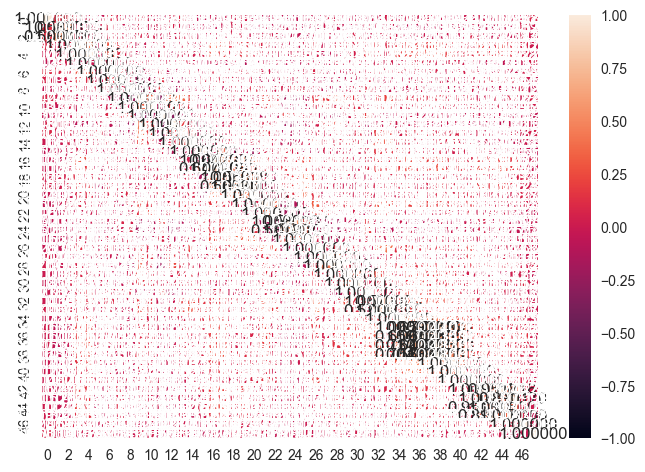

In [60]:
ax = sns.heatmap(cor_mat, vmin=-1, vmax=1, annot=True, fmt="f")
plt.show()

### Principal Component Analysis

In [61]:
# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_scale)
df_x_pca = pl.DataFrame(X_pca , schema= ['PCA1' , 'PCA2' , 'PCA3'])
df_x_pca.head()

PCA1,PCA2,PCA3
f64,f64,f64
-1.569789,-1.799737,-2.540471
3.354198,-0.473336,1.656759
-2.543809,0.152533,1.666427
0.366451,2.971242,0.391742
-1.26852,1.926411,-0.3956


In [62]:
# Explain Variance of PCAs
explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[0.16327914 0.10826402 0.10302565]


In [63]:
# Show the loadings of PCAs
loadings = pca.components_
loadings_df = pl.DataFrame(loadings.T, 
                           schema=['PCA1', 'PCA2', 'PCA3']).select(pl.Series(df_scale.columns).alias('index') ,pl.all()).sort('PCA1' , descending=True)

print(loadings_df)

shape: (48, 4)
┌─────────────────────────────────┬───────────┬───────────┬───────────┐
│ index                           ┆ PCA1      ┆ PCA2      ┆ PCA3      │
│ ---                             ┆ ---       ┆ ---       ┆ ---       │
│ str                             ┆ f64       ┆ f64       ┆ f64       │
╞═════════════════════════════════╪═══════════╪═══════════╪═══════════╡
│ availability_of_benefits_prev_… ┆ 0.481532  ┆ 0.090385  ┆ 0.128792  │
│ anonym_use_benefit_indic_prev_… ┆ 0.476527  ┆ -0.149684 ┆ 0.159744  │
│ employer_importance_mh_vs_ph_p… ┆ 0.300554  ┆ -0.212815 ┆ 0.12937   │
│ mh_resources_availability_indi… ┆ 0.290296  ┆ -0.053772 ┆ 0.176129  │
│ mh_discussion_indic_prev_emplo… ┆ 0.268052  ┆ -0.058604 ┆ 0.140682  │
│ …                               ┆ …         ┆ …         ┆ …         │
│ willing_discuss_ph_in_hiring_i… ┆ -0.000468 ┆ 0.003224  ┆ 0.000041  │
│ neg_consequences_discussing_mh  ┆ -0.000811 ┆ 0.010732  ┆ 0.003648  │
│ prev_employers                  ┆ -0.001725 ┆ 0

## 14. K-Means Clustering

##### Remove a portion of the data to hold back for evaluation and testing

In [64]:
#df.select(pl.count('index')).max().to_series()[0]
df_training = df_scaled.with_row_index().filter(pl.col('index') < df.select(pl.count('index')).max().to_series()[0] * 0.7)
df_training_no_index = df_training.drop('index') 
df_testing = df_scaled.with_row_index().filter(pl.col('index') >= df.select(pl.count('index')).max().to_series()[0] * 0.7)
df_testing_no_index = df_testing.drop('index') 

##### Apply Elbow Method to find ideal K

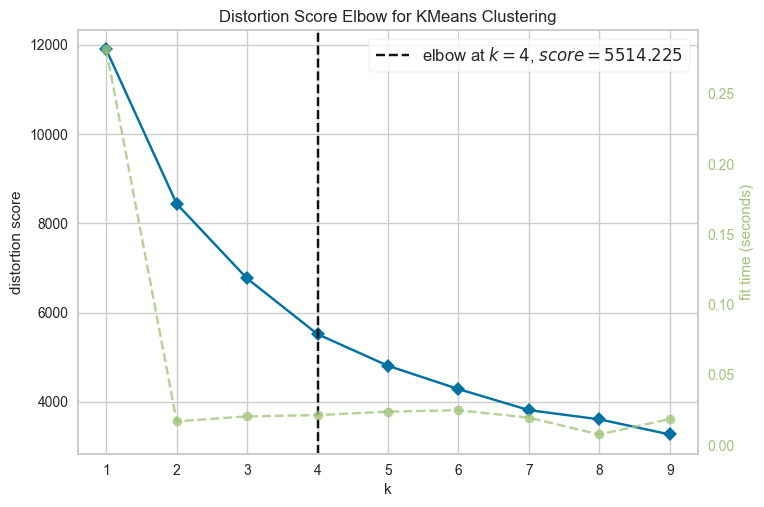

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(df_x_pca.to_pandas())
visualizer.show()

In [66]:
# Fit K-Means Clustering to the training data
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(df_x_pca)

In [67]:
# Show labels
kmeans.labels_

array([0, 1, 2, ..., 1, 0, 0], dtype=int32)

In [68]:
# Make a prediction on the trained K-Means algorithn
prediction_kmean = kmeans.predict(df_x_pca)

In [69]:
# Construct a DataFrame with the clusters
pl_df = pl.DataFrame({'clusters' : prediction_kmean})
testing_data_with_clusters = pl.concat([pl_df , df_x_pca], how="horizontal")

In [70]:
testing_data_with_clusters.head()

clusters,PCA1,PCA2,PCA3
i32,f64,f64,f64
0,-1.569789,-1.799737,-2.540471
1,3.354198,-0.473336,1.656759
2,-2.543809,0.152533,1.666427
0,0.366451,2.971242,0.391742
0,-1.26852,1.926411,-0.3956


In [71]:
# Show the centers of clusters
kmeans.cluster_centers_

array([[-0.42539492,  0.14943524, -1.53918763],
       [ 2.41312522, -0.07605664,  0.61758347],
       [-1.88585799, -0.1006385 ,  1.20054985]])

##### Visualize the clusters

ColumnNotFoundError: "PC1" not found

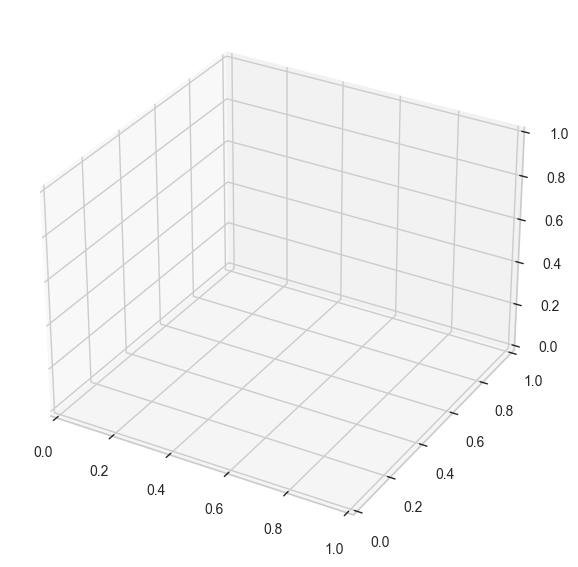

In [72]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each cluster
scatter = ax.scatter(
    testing_data_with_clusters['PCA1'], 
    testing_data_with_clusters['PCA2'], 
    testing_data_with_clusters['PCA3'], 
    c=testing_data_with_clusters['Cluster'],  # Color by cluster
    cmap='viridis',  # You can choose other colormaps like 'plasma', 'coolwarm', etc.
    s=50  # Size of the points
)

# Set labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# Show the plot
plt.show()

In [ ]:
sns.pairplot(testing_data_with_clusters, hue='Cluster', palette='viridis')
plt.show()